# EIS vs. Parameter Measurements

This notebook is an example of how Python can be used to easily measure electrochemical methods multiple times with a varying parameter.

The example shows impedance spectra measured on a Schottky diode at different DC potentials.  
Schottky diodes have a smaller forward voltage of about 0.3 V than silicon diodes with about 0.7 V.

After the measurements, all impedance spectras are plotted together in a [contour plot](https://matplotlib.org/stable/gallery/images_contours_and_fields/contourf_log.html#sphx-glr-gallery-images-contours-and-fields-contourf-log-py) with matplotlib.

In [1]:
import sys
from thales_remote.connection import ThalesRemoteConnection
from thales_remote.script_wrapper import PotentiostatMode,ThalesRemoteScriptWrapper

from zahner_analysis.file_import.ism_import import IsmImport
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import EngFormatter, StrMethodFormatter
from matplotlib import ticker,colors,cm


# Connect Python to the already launched Thales-Software

In [ ]:
if __name__ == "__main__":
    zenniumConnection = ThalesRemoteConnection()
    zenniumConnection.connectToTerm("localhost", "ScriptRemote")
    
    zahnerZennium = ThalesRemoteScriptWrapper(zenniumConnection)
    zahnerZennium.forceThalesIntoRemoteScript()
    
    zahnerZennium.calibrateOffsets()

# Setting the parameters for the measurement

The output path is defined to which the measurement results are saved.  
And it is set that the measuring results are named individually.

Then the parameters for an impedance spectrum are set.

In [ ]:
    zahnerZennium.setEISNaming("individual")
    zahnerZennium.setEISOutputPath(r"C:\THALES\temp")
    
    zahnerZennium.setPotentiostatMode(PotentiostatMode.POTMODE_POTENTIOSTATIC)
    zahnerZennium.setAmplitude(10e-3)
    zahnerZennium.setLowerFrequencyLimit(100)
    zahnerZennium.setStartFrequency(100)
    zahnerZennium.setUpperFrequencyLimit(500000)
    zahnerZennium.setLowerNumberOfPeriods(10)
    zahnerZennium.setLowerStepsPerDecade(10)
    zahnerZennium.setUpperNumberOfPeriods(20)
    zahnerZennium.setUpperStepsPerDecade(10)
    zahnerZennium.setScanDirection("startToMin")
    zahnerZennium.setScanStrategy("single")

# Setting the DC parameters for the measurement

Since impedances are to be measured at different DC potentials, the potentials are stored in the array **potentialsToMeasure**.  
With np.linspace an array is created which contains 13 equally distributed values between 0 and 0.3.

In [4]:
    potentialsToMeasure = np.linspace(0,0.3,13)
    print(potentialsToMeasure)

[0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275
 0.3  ]


# Execute the measurements

For each potential, the file name containing the DC potential is specified and the DC potential is set.  
The potential is stored in the filename in mV and converted to int, because you can not write floating point numbers into the filename, because of the decimal separator.   
The potentiostat is switched on before the EIS measurement that the measurement is executed on the DC potential instead of OCV/OCP.

In [11]:
    for potential in potentialsToMeasure:
        filename = "{:d}_mvdc".format(int(round(potential*1000)))
        print("step: " + filename)
        zahnerZennium.setEISOutputFileName(filename)
        zahnerZennium.setPotential(potential)
    
        zahnerZennium.enablePotentiostat()
        zahnerZennium.measureEIS()
        zahnerZennium.disablePotentiostat()
    
    zahnerZennium.setAmplitude(0)
    zenniumConnection.disconnectFromTerm()

step: 0_mvdc
step: 25_mvdc
step: 50_mvdc
step: 75_mvdc
step: 100_mvdc
step: 125_mvdc
step: 150_mvdc
step: 175_mvdc
step: 200_mvdc
step: 225_mvdc
step: 250_mvdc
step: 275_mvdc
step: 300_mvdc


# Importing data from ism files

The data from the ism files are loaded via the [IsmImport](https://doc.zahner.de/zahner_analysis/file_import/#zahner_analysis.file_import.ism_import.IsmImport) class into Python for further processing.

In [18]:
    absoluteImpedances = []
    phases = []
    
    for potential in potentialsToMeasure:
        ismFile = IsmImport(r"C:\THALES\temp\{:d}_mvdc.ism".format(int(round(potential*1000))))
        absoluteImpedances.append(ismFile.getImpedanceArray())
        phases.append(ismFile.getPhaseArray())

# Preparing the data structures

For the representation with matplotlib it is best to use numpy arrays instead of Python arrays. Therefore numpy arrays are created from the Python arrays with np.array().  
The phase is also converted to degrees and absolute value.

With np.meshgrid() a two-dimensional array is created for X and Y, which is needed by the plotting function, because **absoluteImpedances** and **phases** are also two-dimensional arrays.

In [6]:
    absoluteImpedances = np.array(absoluteImpedances)
    phases = np.array(phases)
    phases = np.abs(phases * (360 / (2 * np.pi)))
    
    impedanceFrequencies = ismFile.getFrequencyArray()
    
    X,Y = np.meshgrid(impedanceFrequencies,potentialsToMeasure)

# Plotting the data

The data is plotted with matplotlib as [contour plot](https://matplotlib.org/stable/gallery/images_contours_and_fields/contourf_log.html#sphx-glr-gallery-images-contours-and-fields-contourf-log-py).

## Impedance Contour Plot

The X-axis corresponds to the frequency, the Y-axis is the DC potential and the impedance is represented by the color.  
For the logarithmic color scaling of the impedance points, the first steps are necessary, since this cannot be done automatically with a parameter.

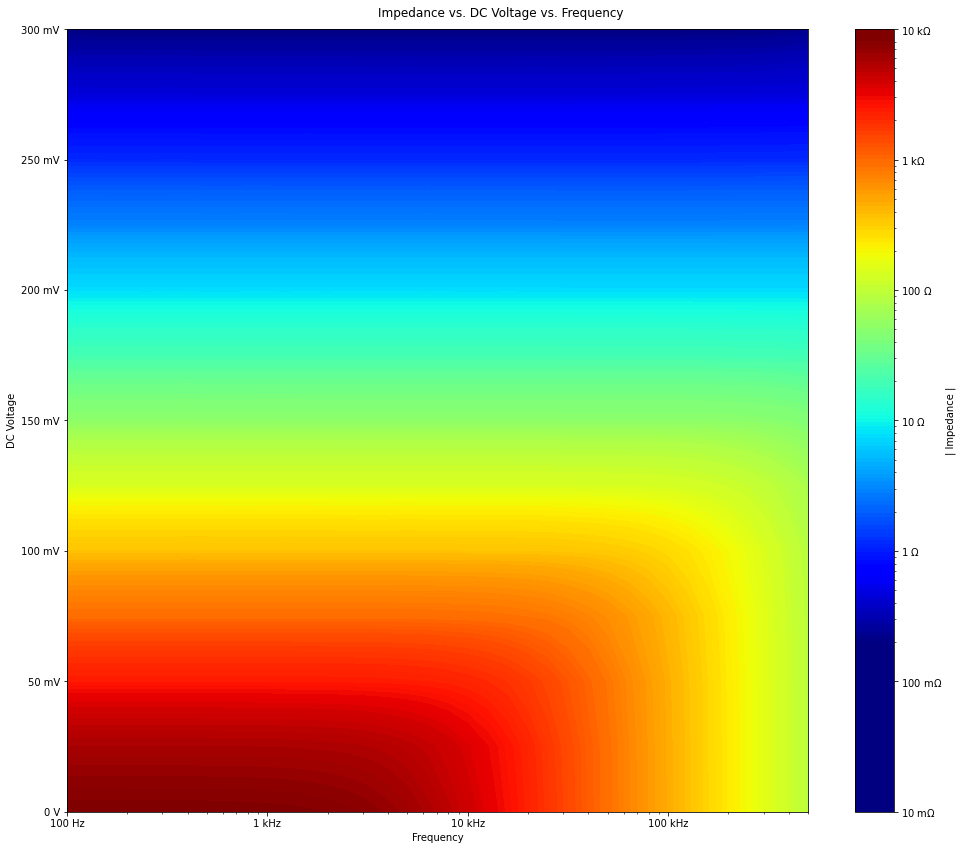

In [17]:
    impedanceFigure, impedancePlot = plt.subplots(1,1)
    impedanceFigure.suptitle("Impedance vs. DC Voltage vs. Frequency")
    
    ticks = np.power(10, np.arange(np.floor(np.log10(absoluteImpedances.min())-1), np.ceil(np.log10(absoluteImpedances.max())+1)))
    levels = np.logspace(np.floor(np.log10(absoluteImpedances.min())-1), np.ceil(np.log10(absoluteImpedances.max())), num=200)
    impedanceContour = impedancePlot.contourf(X, Y, absoluteImpedances, levels = levels, norm = colors.LogNorm(absoluteImpedances.min(), absoluteImpedances.max(), True), cmap="jet")
    
    impedancePlot.set_xlabel(r"Frequency")
    impedancePlot.set_xscale("log")
    impedancePlot.xaxis.set_major_formatter(EngFormatter(unit="Hz"))
    
    impedancePlot.set_ylabel(r"DC Voltage")
    impedancePlot.yaxis.set_major_formatter(EngFormatter(unit="V"))
    
    impedanceBar = impedanceFigure.colorbar(impedanceContour, ticks=ticks, format=EngFormatter(unit="$\Omega$"))
    impedanceBar.set_label('| Impedance |')
    impedanceFigure.set_size_inches(14, 12)
    plt.tight_layout()
    plt.show()
    impedanceFigure.savefig("impedance_contour.svg")

## Phase Contour Plot

The X-axis corresponds to the frequency, the Y-axis is the DC potential and the phase is represented by the color.  
This plot is basically the same as the impedance plot, but the settings of matplotlib are simpler, because the colors do not have to be scaled logarithmically.

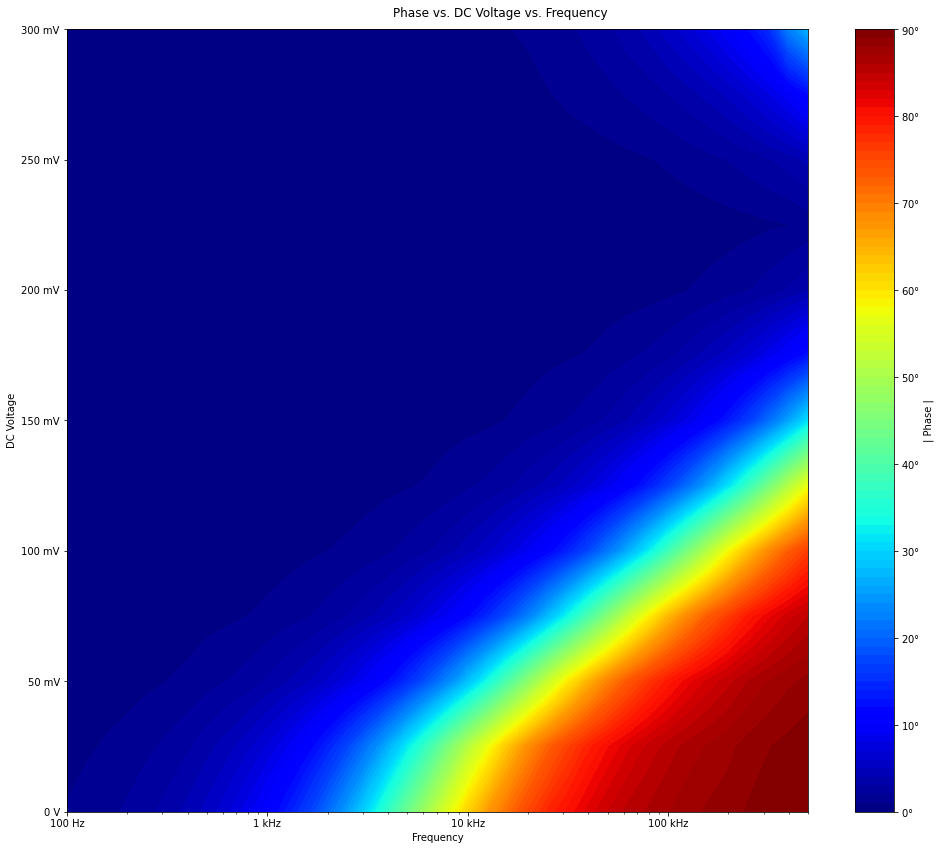

In [16]:
    phaseFigure, phasePlot = plt.subplots(1, 1)
    phaseFigure.suptitle("Phase vs. DC Voltage vs. Frequency")

    levels = np.linspace(phases.min(), phases.max(), 91)
    phaseContour = phasePlot.contourf(X, Y, phases, levels = levels, cmap="jet")

    phasePlot.set_xlabel(r"Frequency")
    phasePlot.set_xscale("log")
    phasePlot.xaxis.set_major_formatter(EngFormatter(unit="Hz"))

    phasePlot.set_ylabel(r"DC Voltage")
    phasePlot.yaxis.set_major_formatter(EngFormatter(unit="V"))

    phaseBar = phaseFigure.colorbar(phaseContour, format=StrMethodFormatter("{x:.0f}$°$"))
    phaseBar.set_label("| Phase |")

    phaseFigure.set_size_inches(14, 12)
    plt.tight_layout()
    plt.show()
    phaseFigure.savefig("phase_contour.svg")

The previous plot shows that the impedance of the Schottky diode is high at low DC potential and in the high frequency region with 90 degrees phase capacitive behavior is present, which is due to the junction capacitance. With higher DC potential, the impedance becomes lower and lower as the diode begins to conduct. At higher DC voltage, a small phase shift for inductive behavior is also seen.